### Initialize Jupyter Notebook and assign GPU

In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"

### Load utility functions

In [2]:
from utils import *
from models import *
from dataloader import *
from torch.optim import SGD

### Set Experiment Configs

In [8]:
#The name of the first and second split datasets. Keep these same
dataset1 = "mnist"
dataset2 = "mnist"


#Training parameters for first and second split training
weight_decay = 5e-4
peak_lr_pre = 0.1
peak_lr_ft = 0.1
batch_size = 512

#Label Noise Ratio in first and second split
label_noise_ratio_pre = 0.0
label_noise_ratio_ft = 0.0

#Model type and learning schedule
model_type = "resnet9" 
schedule = "triangle" 
seed = 0

#Extra Parameters, not needed
minority_1 = 0
minority_2 = 0

all_args = {"dataset1":dataset1, "dataset2":dataset2, "wd":weight_decay, "lr1":peak_lr_pre, "lr2":peak_lr_ft, 
            "noise_1":label_noise_ratio_pre, "noise_2":label_noise_ratio_ft, "model":model_type, "schedule":schedule,
            "minority_1":minority_1, "minority_2":minority_2, "seed":seed, "batch_size":batch_size, "log_factor":0,"seed_superclass":0}

### Get dataset splits

In [9]:
#Dictionary containing first and second split data loaders, noise mask and other data-dependent quantities
pre_dict, ft_dict = return_loaders(all_args)
print(pre_dict.keys())
preloader = pre_dict["train_loader"]
ftloader = ft_dict["train_loader"]

### Model Initialization

In [10]:
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0)
in_channels = 1 if all_args["dataset1"] == "mnist" else 3
model = get_model(all_args["model"], in_channels=in_channels)

### Model Training

In [12]:
#Stage 1 Training
optimizer = SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler, EPOCHS = get_scheduler_epochs(all_args["schedule"], optimizer, preloader)

ret_pre = train(model, preloader, optimizer, scheduler, loss_fn, EPOCHS = EPOCHS,eval_every = True, eval_loader= preloader)

torch.save(model.state_dict(), f"models/{all_args['dataset1']}/stage_1.pt")


#Stage 2 Training
optimizer = SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler, EPOCHS = get_scheduler_epochs(all_args["schedule"], optimizer, ftloader)


ret_ft = train(model, ftloader, optimizer, scheduler, loss_fn, EPOCHS = EPOCHS, eval_every = True, eval_loader= preloader)

torch.save(model.state_dict(), f"models/{all_args['dataset1']}/stage_2.pt")

Epoch: 1 | Eval Loader Accuracy: 63.6167%
Epoch: 1 | Train Mode Eval Loader Accuracy: 63.6167%
Epoch: 2 | Eval Loader Accuracy: 90.9633%
Epoch: 2 | Train Mode Eval Loader Accuracy: 90.9633%
Epoch: 3 | Eval Loader Accuracy: 95.6633%
Epoch: 3 | Train Mode Eval Loader Accuracy: 95.6633%
Epoch: 4 | Eval Loader Accuracy: 96.8733%
Epoch: 4 | Train Mode Eval Loader Accuracy: 96.8733%
Epoch: 5 | Eval Loader Accuracy: 97.4167%
Epoch: 5 | Train Mode Eval Loader Accuracy: 97.4167%
Epoch: 5 | Accuracy: 97.1167% | Loss: 1.82e-04
Epoch: 6 | Eval Loader Accuracy: 98.4467%
Epoch: 6 | Train Mode Eval Loader Accuracy: 98.4467%
Epoch: 7 | Eval Loader Accuracy: 98.4367%
Epoch: 7 | Train Mode Eval Loader Accuracy: 98.4367%
Epoch: 8 | Eval Loader Accuracy: 98.4733%
Epoch: 8 | Train Mode Eval Loader Accuracy: 98.4733%
Epoch: 9 | Eval Loader Accuracy: 98.6267%
Epoch: 9 | Train Mode Eval Loader Accuracy: 98.6267%
Epoch: 10 | Eval Loader Accuracy: 98.9167%
Epoch: 10 | Train Mode Eval Loader Accuracy: 98.9167%
E

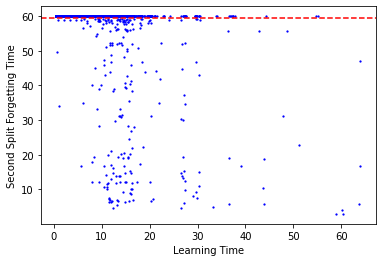

In [21]:
masks_pre = ret_pre["acc_mask"]
masks_ft = ret_ft["acc_mask"]
noise_mask = pre_dict["noise_mask"]

learn_epochs = get_first_epoch_where_we_learn_forever(masks_pre)
forget_epochs = get_first_epoch_where_we_forget_forever(masks_ft)
learn = learn_epochs + np.random.uniform(-0.5, 0.5, size = learn_epochs.shape)
forget = forget_epochs 
fg = forget_epochs.max()
forget[forget_epochs!=fg] = forget[forget_epochs!=fg] + np.random.uniform(-0.4, 0.4, size = forget_epochs[forget_epochs!=fg].shape)
plt.xlabel("Learning Time")
plt.ylabel("Second Split Forgetting Time")

plt.axhline(y=fg-0.5, color='r', linestyle='--')
plt.scatter(learn, forget, s= 1.5, c = "b")

In [107]:
import matplotlib
import numpy as np

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.use('svg')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['font.family'] = "serif"
matplotlib.rcParams['font.sans-serif'] = "Times New Roman"

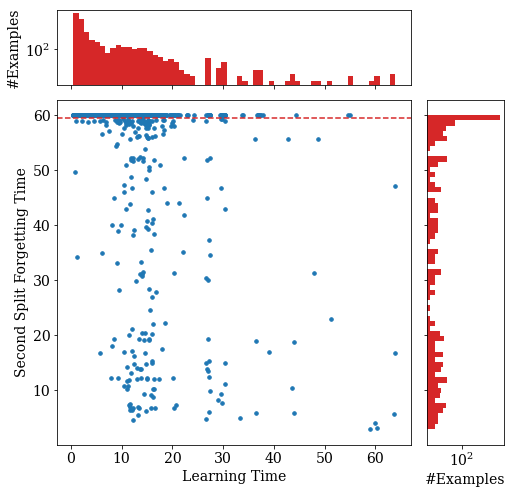

In [108]:
import matplotlib.gridspec as gridspec

x, y  = learn, forget
fig = plt.figure(figsize=(8,8))
gs = gridspec.GridSpec(5, 5)
ax_main = plt.subplot(gs[1:, :4])
ax_xDist = plt.subplot(gs[0, :4])#,sharex=ax_main)
ax_yDist = plt.subplot(gs[1:, 4])#,sharey=ax_main)

ax_main.scatter(x,y,marker='.',c='tab:blue',s=50)
ax_main.set(xlabel="Learning Time", ylabel="Second Split Forgetting Time")
ax_main.axhline(y=fg-0.5, color='tab:red', linestyle='--', c = 'tab:red')
ax_xDist.hist(x,bins=61,color='tab:red',align='mid')
ax_xDist.set(ylabel='#Examples')

ax_yDist.hist(y,bins=61,color='tab:red', orientation='horizontal',align='mid')
ax_yDist.set(xlabel='#Examples')

ax_xDist.set_yscale('log')
ax_yDist.set_xscale('log')
ax_yDist.set_yticklabels([])
ax_xDist.set_xticklabels([])


plt.savefig("plots/mnist_vis.svg")
plt.show()

In [97]:
import pickle
with open('mnist_final.pickle', 'wb') as handle:
    pickle.dump([learn, forget], handle, protocol=pickle.HIGHEST_PROTOCOL)

tensor([7, 1, 9, 4])


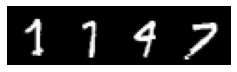

In [106]:
idx = (forget_epochs<10) & (learn_epochs>45)
imshow(pre_dict["train_dataset"].data[idx][:4], loc = "plots/mnist_bottom_right.png", rotate = )
print(pre_dict["train_dataset"].targets[idx][:4])